In [1]:
import numpy as np
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X = np.load("/content/drive/MyDrive/data sem thesis abhishek/normalised_data/X_datagen_allcomb_foreign_class_fixed_more_latest_normalised.npy")
X.shape

(180000, 1000)

In [4]:
y = np.load("/content/drive/MyDrive/data sem thesis abhishek/normalised_data/y_datagen_allcomb_foreign_hotencoding_fixed_more_latest_normalised.npy")
y.shape

(180000, 5)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle = True, random_state = 34)

In [7]:
import pickle

In [8]:
import tensorflow as tf

In [9]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc1 = tf.keras.layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(channels, activation='sigmoid')

    def call(self, x):
        x_se = self.avg_pool(x)
        x_se = self.fc1(x_se)
        x_se = self.fc2(x_se)
        x_se = tf.reshape(x_se, [-1, 1, self.channels])
        x = x * x_se
        return x

    
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Layers
        self.conv1 = tf.keras.layers.Conv1D(out_channels, kernel_size=5,
                                            strides=stride, padding='same',
                                            dilation_rate=1, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.se = SEBlock(out_channels)
        self.conv2 = tf.keras.layers.Conv1D(out_channels, kernel_size=5,
                                            strides=1, padding='same',
                                            dilation_rate=1, use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.shortcut = tf.keras.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = tf.keras.Sequential([
                tf.keras.layers.Conv1D(out_channels, kernel_size=1,
                                        strides=stride, use_bias=False),
                tf.keras.layers.BatchNormalization()
            ])

    def call(self, x):
        out = tf.nn.relu(self.bn1(self.conv1(x)))
        out = self.se(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = tf.nn.relu(out)
        return out


class ResNet(tf.keras.Model):
    def __init__(self, hidden_sizes, num_blocks, input_dim=1000,
                 in_channels=64, n_classes=5):
        super(ResNet, self).__init__()
        assert len(num_blocks) == len(hidden_sizes)
        self.input_dim = input_dim
        self.in_channels = in_channels
        self.n_classes = n_classes
        
        self.conv1 = tf.keras.layers.Conv1D(in_channels, kernel_size=5,
                                            strides=1, padding='same',
                                            use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        # Flexible number of residual encoding layers
        layers = []
        strides = [1] + [2] * (len(hidden_sizes) - 1)
        for idx, hidden_size in enumerate(hidden_sizes):
            layers.append(self._make_layer(hidden_size, num_blocks[idx],
                                            stride=strides[idx]))
        self.encoder = tf.keras.Sequential(layers)

        self.global_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.z_dim = self._get_encoding_size()
        self.linear = tf.keras.layers.Dense(n_classes, activation='sigmoid')


    def encode(self, x):
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = self.encoder(x)
        x = self.global_pooling(x)
        return x

    def call(self, x):
        z = self.encode(x)
        logits = self.linear(z)
        return logits


    def _make_layer(self, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for stride in strides:
            blocks.append(ResidualBlock(self.in_channels, out_channels,
                                            stride=stride))
            blocks.append(SEBlock(out_channels))
            self.in_channels = out_channels
        return tf.keras.Sequential(blocks)


    def _get_encoding_size(self):
        """
        Returns the dimension of the encoded input.
        """
        temp = tf.random.normal((1, self.input_dim, 1))
        z = self.encode(temp)
        z_dim = z.shape[1]
        return z_dim

In [10]:
model = pickle.load(open('/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_50_0.pkl','rb'))
train_pred0 = model.predict(X_train.reshape(-1,1000,1))
test_pred0 = model.predict(X_test.reshape(-1,1000,1))

model = pickle.load(open('/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_50_1.pkl','rb'))
train_pred1 = model.predict(X_train.reshape(-1,1000,1))
test_pred1 = model.predict(X_test.reshape(-1,1000,1))

model = pickle.load(open('/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_50_2.pkl','rb'))
train_pred2 = model.predict(X_train.reshape(-1,1000,1))
test_pred2 = model.predict(X_test.reshape(-1,1000,1))

model = pickle.load(open('/content/drive/MyDrive/data sem thesis abhishek/New_models/senet_individual_50_3.pkl','rb'))
train_pred3 = model.predict(X_train.reshape(-1,1000,1))
test_pred3 = model.predict(X_test.reshape(-1,1000,1))

1407/1407 [==============================] - 13s 9ms/step


In [11]:
del model

In [12]:
train_pred0 = np.where(train_pred0 > 0.5,1,0) 
train_pred1 = np.where(train_pred1 > 0.5,1,0) 
train_pred2 = np.where(train_pred2 > 0.5,1,0) 
train_pred3 = np.where(train_pred3 > 0.5,1,0) 

test_pred0 = np.where(test_pred0 > 0.5,1,0) 
test_pred1 = np.where(test_pred1 > 0.5,1,0) 
test_pred2 = np.where(test_pred2 > 0.5,1,0) 
test_pred3 = np.where(test_pred3 > 0.5,1,0) 

In [13]:
train_pred = np.concatenate([train_pred0,train_pred1,train_pred2,train_pred3],axis = 1)
test_pred = np.concatenate([test_pred0,test_pred1,test_pred2,test_pred3],axis = 1)

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [15]:
print(classification_report(train_pred[:,0],y_train[:,0]))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     67199
           1       0.93      0.99      0.96     67801

    accuracy                           0.96    135000
   macro avg       0.96      0.96      0.96    135000
weighted avg       0.96      0.96      0.96    135000



In [16]:
print(classification_report(test_pred[:,0],y_test[:,0]))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     22477
           1       0.85      0.91      0.88     22523

    accuracy                           0.88     45000
   macro avg       0.88      0.88      0.88     45000
weighted avg       0.88      0.88      0.88     45000



In [17]:
print(classification_report(train_pred[:,1],y_train[:,1]))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     71283
           1       0.88      1.00      0.94     63717

    accuracy                           0.94    135000
   macro avg       0.94      0.94      0.94    135000
weighted avg       0.94      0.94      0.94    135000



In [18]:
print(classification_report(test_pred[:,1],y_test[:,1]))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     24260
           1       0.85      0.99      0.92     20740

    accuracy                           0.92     45000
   macro avg       0.92      0.92      0.92     45000
weighted avg       0.93      0.92      0.92     45000



In [19]:
print(classification_report(train_pred[:,2],y_train[:,2]))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     63755
           1       0.96      0.97      0.96     71245

    accuracy                           0.96    135000
   macro avg       0.96      0.96      0.96    135000
weighted avg       0.96      0.96      0.96    135000



In [20]:
print(classification_report(test_pred[:,2],y_test[:,2]))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80     20863
           1       0.83      0.81      0.82     24137

    accuracy                           0.81     45000
   macro avg       0.81      0.81      0.81     45000
weighted avg       0.81      0.81      0.81     45000



In [21]:
print(classification_report(train_pred[:,3],y_train[:,3]))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     62109
           1       0.96      0.95      0.95     72891

    accuracy                           0.95    135000
   macro avg       0.95      0.95      0.95    135000
weighted avg       0.95      0.95      0.95    135000



In [22]:
print(classification_report(test_pred[:,3],y_test[:,3]))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77     19305
           1       0.85      0.79      0.82     25695

    accuracy                           0.80     45000
   macro avg       0.79      0.80      0.79     45000
weighted avg       0.80      0.80      0.80     45000



In [23]:
s = 0
for i in range(4):
  s += accuracy_score(train_pred[:,i],y_train[:,i])

s = s/4
print("train_accuracy :",s)

train_accuracy : 0.9518518518518518


In [32]:
s = 0
for i in range(4):
  s += accuracy_score(test_pred[:,i],y_test[:,i])

s = s/4
print("test_accuracy :",s)

test_accuracy : 0.8610451511427633


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

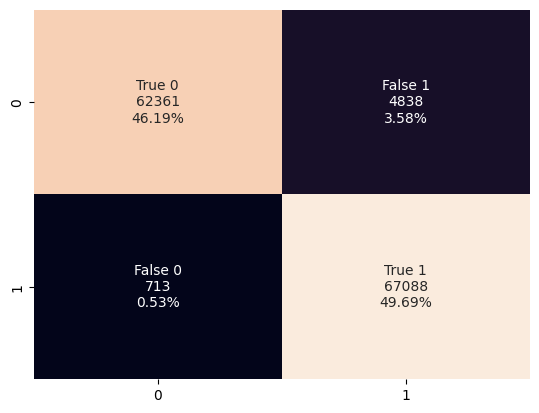

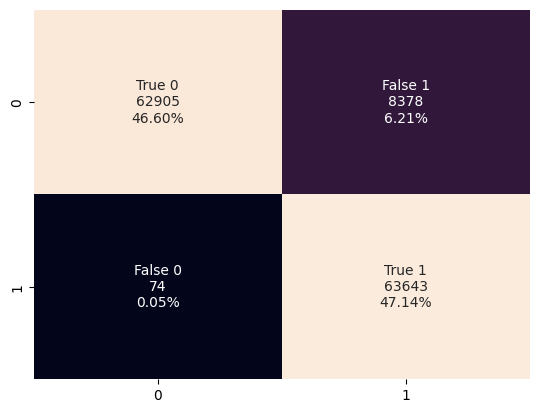

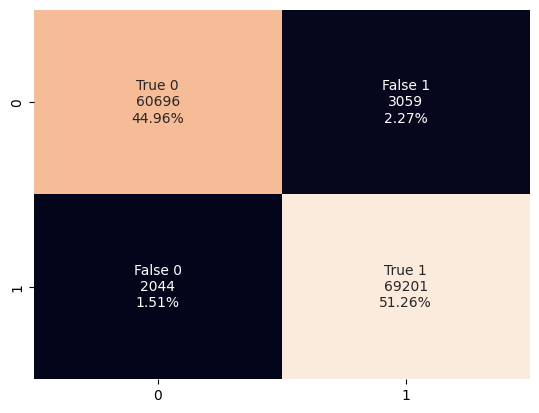

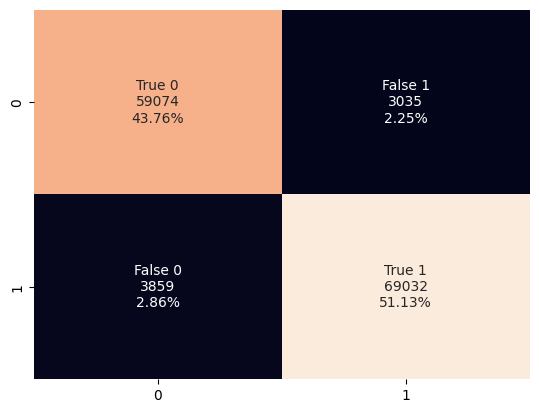

In [26]:
for i in range(4):
  cf = confusion_matrix(train_pred[:,i],y_train[:,i])
  group_names = ["True 0","False 1","False 0","True 1"]
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(i)
  sns.heatmap(cf/np.sum(cf), annot=labels,cbar = False, fmt = "")

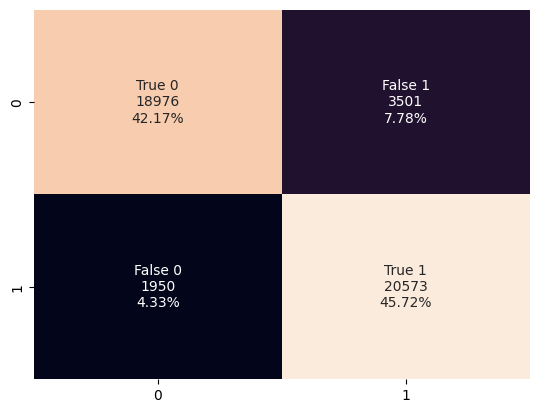

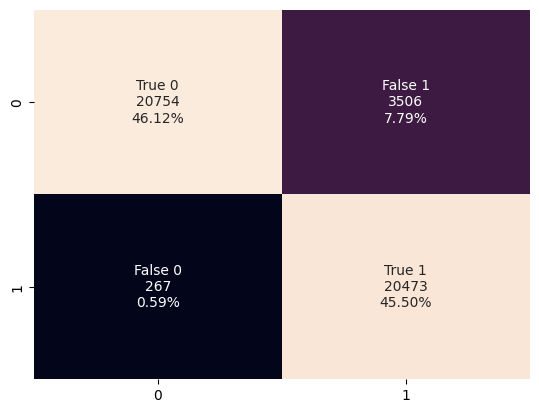

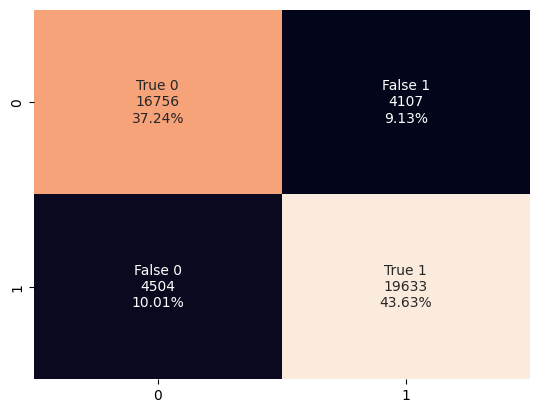

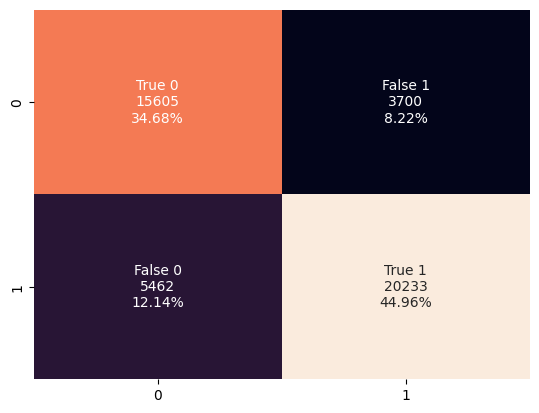

In [27]:
for i in range(4):
  cf = confusion_matrix(test_pred[:,i],y_test[:,i])
  group_names = ["True 0","False 1","False 0","True 1"]
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(i)
  sns.heatmap(cf/np.sum(cf), annot=labels,cbar = False, fmt = "")